## Introduction

Image classification is one of the most useful but difficult problems in our life. If we can classify images automatically, we will be able to save a lot of human resources and money. For example, online shopping websites can classify their items into different categories automatically based on the images of items. Fortunately, in the modern world, the explosive growth of data and much more powerful machines give us more access to deal with our problems. In recent years, researchers find that using some deep learning methods can greatly improve the accuracy of image classification. Based on this point, this tutorial will cover some basic topics in image processing and image classification using some deep learning methods. Typically, we will introduce Convolutional Neural Network(CNN), which shows great performance in image classification. 

### Tutorial content

In this tutorial, we will show some basic image operations of [Pillow](https://pillow.readthedocs.io/en/latest/), then we will talk about how to load data, build a Convolutional Neural Network, train the network step by step in a popular deep learning framework called [Pytorch](http://pytorch.org/). In addition, to show the images we use, we need the help of [Matplotlib](https://matplotlib.org/)

There are two datasets being used in this tutorial. The first one is [ImageNet](www.image-net.org/) and the other is [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). ImageNet is a very big and robust image dataset, which means it needs very complex network and a lot of time to train. Therefore, we will just use a pretrained [Alexnet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) to show how amazing deep learning can be. Then we will use a smaller dataset CIFAR-10 to show how to train a simple deep learning model by ourselves.

The tutorial will be organized in the following order:
- [Installing the libraries](#Installing-the-libraries)
- [Library introduction: Pytorch and Pillow](#Library-introduction:-Pytorch-and-Pillow)
- [Retrieve image and visualization](#Retrieve-image-and-visualization)
- [Dataset and Dataloader](#Dataset-and-Dataloader)
- [Convolutional neural network](#Convolutional-neural-network)
- [Example application: Alexnet knows what you are](#Example-application:-Alexnet-know-what-you-are)
- [Example application: Train your CNN on CIFAR](#Train-your-CNN-on-CIFAR)

## Installing the libraries

You need to install the packages before getting started. 

If you are using [Anaconda](https://anaconda.org/) to manage your environment, you can use the following command to install the packages.

> $ conda install pytorch torchvision -c pytorch

> $ conda install matplotlib

If not, you have to follow the instructions on [Pytorch](http://pytorch.org/) and [Matplotlib](https://matplotlib.org/users/installing.html) to install the packages, which depends on your operating system.

If you cannot install the packages successfully, connect me or just see the results pre-outputed.

## Library introduction: Pytorch and Pillow

[Pytorch](http://pytorch.org/) is Python package for scientific computing that can works well with those popular Python computing packages like Numpy, Scipy, etc. Specificly, Pytorch provides maximum flexibility to build deep learning networks and great support to use the power of GPUs, so we can use Pytorch to show how deep learning/neural networks works quickly and intuitively.

[Pillow](https://pillow.readthedocs.io/en/latest/) is a keep-updated forked PIL(Python Image Library), maintained by Alex Clark and other contributors. Pillow allows us to do some basic image manipulations in Python.

Once you have installed required packages, you should run the following imports successfully.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from io import BytesIO
from urllib import request
import matplotlib.pyplot as plt
import numpy as np
import json
import time

## Retrieve image and visualization

Firstly, let's get an image from a URL, which is a very basic operation in image classification. Imagine that you want to write a crawler to crawl images from the Internet, you will need this function to transform the crawled url to a true image.

In [2]:
def retrieve_image(url):
    """Get the image from a given URL"""
    with request.urlopen(url) as u:
        f = BytesIO(u.read())
    img = Image.open(f)
    return img

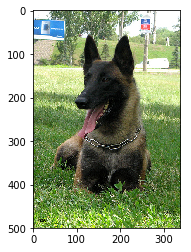

In [3]:
# Retrieve an image(you are free to change url to get another image and see what will change in the following cells)
image = retrieve_image("http://farm2.static.flickr.com/1015/637892189_dc58cb88e9.jpg")

# Show the image we get.
plt.imshow(image)
plt.show()

Now we see the image we want, then we can figure out some statistics behind it. Use the histogram as an example.

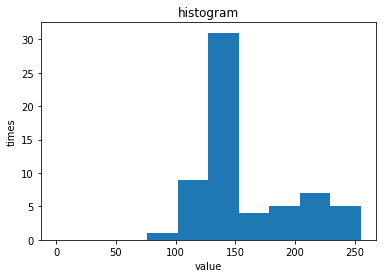

In [21]:
histogram = image.histogram()
plt.hist(histogram, range=(0,255))
plt.title('histogram')
plt.xlabel('value')
plt.ylabel('times')
plt.show()

Also, we can do some image operations on it, like rotate and resize. Here we are going to the resize the image into (224, 224), because in our first application example, the network requires a (224, 224) size input.

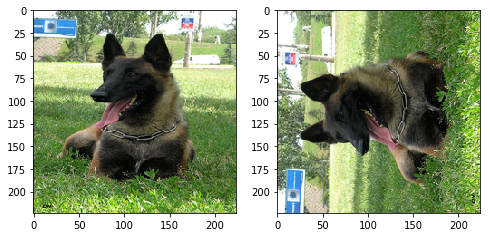

In [5]:
# Resize the image to 224 X 224, which matches the pretrained model.
resized_image = image.resize((224, 224), Image.ANTIALIAS)
rotated_resized_image = resized_image.rotate(90)

fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(resized_image)
fig.add_subplot(1, 2, 2)
plt.imshow(rotated_resized_image)
plt.show()

## Dataset and Dataloader

Before we dive into the deep learning and Pytorch part, let's define some useful parameters.

The 100 in "input_feature" is calculated based on our image size, kernel size, stride and padding in our convolutional neural network, so feel free to skip that number if you are not familiar with CNN.

In [6]:
batch_size = 32 # How many images in a batch
learning_rate = 0.001 
input_channel = 3  #Input channel in CNN, 3 for RGB.
output_channel1 = 8 # Number of channels in 1st hidden layer
output_channel2 = 16 # Number of channels in 2nd hidden layer
output_channel3 = 32 # Number of channels in 3rd hidden layer
input_feature = output_channel3 * 100 # Sum of features 
output_feature = 10 # Number of output labels, as we use CIFAR-10 which has 10 different categories, this number is 10.
epoch_num = 5 # How many epochs we are going to train our model through our training data.

Dataset and Dataloader are very important parts in Pytorch, which provide a convenient and powerful way to let you use your data. Basicly, you can use the default Dataset and Dataloader class to load some well formatted dataset. If you want to do some specific preprocessing, you can extend the Dataset and Dataloader class and override some of the methods to achieve your goal. In the following code, we first initialize two datasets with normalization, then write a custom dataset class to split the original training set into training set and validation set.

In [7]:
# Download CIFAR-10 dataset and transform it for later usage.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


In [8]:
# Use this part to split the original train set into train set and validation set.
class FullDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, offset, length):
        super(FullDataset, self).__init__()
        self.dataset = dataset
        self.offset = offset
        self.length = length
        assert len(dataset) >= offset+length
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, i):
        return self.dataset[i + self.offset]
        
def split_dataset(dataset, valid_prop=0.2):
    valid_offset = int(len(dataset)*(1 - valid_prop))
    return FullDataset(dataset, 0, valid_offset), FullDataset(dataset, valid_offset, len(dataset) - valid_offset)

In [9]:
trainset, validset = split_dataset(dataset)
train_size = len(trainset)
valid_size = len(validset)
test_size = len(testset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, 
                                         shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False)

## Convolutional Neural Network

Convolutional Neural Network is a very popular network in image classification. The main point of its magic is that it uses a convolutional kernel to sweep through the original image and extract some local features out. If traditional neural network want to achieve the same effect, it needs a fully connected layer that flattens every convolutional kernel into a a simple layer, which means it has much more neurons and more parameters to learn. Therefore, comparing to normal neural network, a convolutional neural network significantly reduces the number of parameters we need to train and it is easier to extract local features to get better performance.

If you want to learn more about Convolutional Neural Network concepts, please refer to this [note](http://cs231n.github.io/convolutional-networks/).

Now let's define a simple 3-layer convolutional neural network in Pytorch and we will use this network to train a image classifier on CIFAR-10 later.

In [10]:
class CNN(nn.Module):
    """Using this convolutional neural network to train CIFAR-10.
    This is just to show how CNN works"""
    def __init__(self):
        super(CNN, self).__init__()
        self.cv1 = nn.Conv2d(in_channels=input_channel, out_channels=output_channel1, kernel_size=3, stride=1, padding=0)
        self.cv2 = nn.Conv2d(in_channels=output_channel1, out_channels=output_channel2, kernel_size=3, stride=1, padding=1)
        self.cv3 = nn.Conv2d(in_channels=output_channel2, out_channels=output_channel3, kernel_size=3, stride=1, padding=1)
        self.pooling = nn.MaxPool2d(kernel_size=3)
        self.projection = nn.Linear(output_channel3 * 100, output_feature)
    
    def forward(self, X):
        X = F.leaky_relu(self.cv1(X))
        X = F.leaky_relu(self.cv2(X))
        X = F.leaky_relu(self.cv3(X))
        X = self.pooling(X)
        X = X.view(-1, output_channel3 * 100)
        X = self.projection(X)
        return X

## Example application: Alexnets know what you are

In this part, we will use a pretrained [Alexnet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) to classify an image. Alexnet is a well-performed complex convolutional neural network published in 2012.

First of all, let's define some helper functions in advance. 
- "normalize" will normalize the input image same as the dataset using to train the model.
- "to_tensor" will transform a image to tensor.
- "to_variable()" will transform Pytorch tensor to Variable. If GPU is available, put the data on GPU to accelerate.
- "get_imagenet_labels()" will get the 1000 labels of Imagenet dataset and transform it to a easy-to-use format.
- "predict()" will use the input model and labels to predict the category of input image.

In [11]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def to_variable(x):
    if torch.cuda.is_available():
        return Variable(x).cuda()
    return Variable(x)

def get_imagenet_labels():
    #Get the labels of ImageNet, transform to a list
    json_url = "http://files.fast.ai/models/imagenet_class_index.json"
    with request.urlopen(json_url) as u:
        json_data = u.read()
    class_idx = json.loads(json_data)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    return idx2label

def predict(image, model, labels):
    #Predict the label of input image with input model
    X = to_tensor(image)
    X = normalize(X).unsqueeze(0)
    X = to_variable(X)
    Y = model(X)
    pred = Y.data.max(1, keepdim=True)[1]
    return labels[int(pred)]

Let's check our input image again.

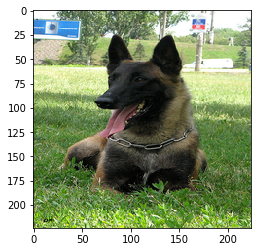

In [12]:
plt.imshow(resized_image)
plt.show()

Ok, it's the dog we saw before. Now it's time for Alexnet to guess.

In [13]:
alexnet = models.alexnet(pretrained=True)
labels = get_imagenet_labels()
prediction = predict(resized_image, alexnet, labels)
print("Alexnet: The category of your input image is {0}".format(prediction))

Alexnet: The category of your input image is malinois


## Example application: Train your CNN on CIFAR

In the last example, we see the power of Convolutional Neural Network. In this example, we will train a much simpler convolutional neural network to show the process of training in Pytorch. More specificly, we will train a 3-layer convolutional neural network on the CIFAR-10 dataset for 5 epochs and test the accuracy of our model.

Before we start, we are going to introduce some basic concepts in training.
- Loss function is a function that calculates the difference between the predicted labels our model produces and the true labels given by training set.
- Optimizer is used to make our model learn. It propagates back the loss we calculated to make our model update its parameters.

In [14]:
# Use the validation set to validate our model.
def validate(model, loader, size):
    correct = 0
    for data, label in loader:
        X = to_variable(data)
        Y = to_variable(label)
        out = model(X)
        pred = out.data.max(1, keepdim=True)[1]
        predicted = pred.eq(Y.data.view_as(pred))
        correct += predicted.sum()
    return correct / size
    
# Train the model.
def train(model, optimizer, loader, size, epochs):
    print("Begin training...")
    loss_func = nn.CrossEntropyLoss() 
    train_loss_stat = []
    train_acc_stat = []
    valid_acc_stat = []
    for e in range(epochs):
        epoch_loss = 0
        ite_loss = 0
        correct = 0
        start = time.time()
        for batch_idx, (data, label) in enumerate(loader):
            # Everytime we get a batch(32 images in this example) and use it to train
            # Remember to zero_grad the optimizer every loop, or you will run out of memory.
            optimizer.zero_grad()
            X = to_variable(data)
            Y = to_variable(label)
            out = model(X) #output of our model will be a (batch_size, 10) tensor
            
            pred = out.data.max(1, keepdim=True)[1] # pick the most probable label as our prediction
            predicted = pred.eq(Y.data.view_as(pred))
            correct += predicted.sum()
            
            loss = loss_func(out, Y) # Calculate the loss
            loss.backward() # back propagation
            optimizer.step() 
            epoch_loss += loss.data[0]
            ite_loss += loss.data[0]
            stop = time.time()
            if (batch_idx + 1) % 200 == 0:
                # Everytime we learn 200 batches, print helper message.
                ite_num = (batch_idx + 1)
                total_num = size // batch_size + 1
                train_loss_stat.append(ite_loss/200)
                print("Iteration:{0}/{1}, Time:{2:.2f}, Loss:{3:.8f}".format(ite_num, total_num, stop - start, ite_loss/200))
                start = time.time()
                ite_loss = 0
                
        # Calculate some statistics to help us know the learning process.
        total_loss = epoch_loss/size * batch_size
        train_acc = (1.0 * correct/size) * 100
        valid_acc = (1.0 * validate(model, validloader, valid_size)) * 100
        train_acc_stat.append(train_acc)
        valid_acc_stat.append(valid_acc)
        print("epoch:{0}, loss:{1:.8f}, train accuracy:{2:.4f}%, validation accuracy:{3:.4f}%".format(e+1, total_loss, train_acc, valid_acc))
            
    return (train_loss_stat, train_acc_stat, valid_acc_stat)

In [15]:
# Initialize the CNN we built before.
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss_stat, train_acc_stat, valid_acc_stat = train(model, optimizer, trainloader, train_size, epoch_num)

Begin training...
Iteration:200/1251, Time:19.14, Loss:1.92746165
Iteration:400/1251, Time:19.34, Loss:1.61195066
Iteration:600/1251, Time:18.53, Loss:1.47589278
Iteration:800/1251, Time:21.80, Loss:1.37370972
Iteration:1000/1251, Time:18.22, Loss:1.28675242
Iteration:1200/1251, Time:15.96, Loss:1.26378955
epoch:1, loss:1.47619777, train accuracy:47.2950%, validation accuracy:57.5600%
Iteration:200/1251, Time:16.12, Loss:1.15595079
Iteration:400/1251, Time:16.51, Loss:1.11594908
Iteration:600/1251, Time:16.42, Loss:1.13151167
Iteration:800/1251, Time:17.12, Loss:1.08429683
Iteration:1000/1251, Time:15.47, Loss:1.07950861
Iteration:1200/1251, Time:15.76, Loss:1.07246151
epoch:2, loss:1.10303086, train accuracy:61.4950%, validation accuracy:63.7100%
Iteration:200/1251, Time:15.52, Loss:0.96964729
Iteration:400/1251, Time:19.73, Loss:0.96431750
Iteration:600/1251, Time:16.62, Loss:0.94787458
Iteration:800/1251, Time:16.19, Loss:1.00268850
Iteration:1000/1251, Time:16.27, Loss:0.96336242
I

Then we are going to plot the loss and accuracy during training.

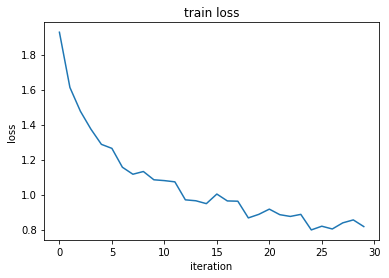

In [16]:
# Plot the train loss
plt.plot(train_loss_stat)
plt.title('train loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

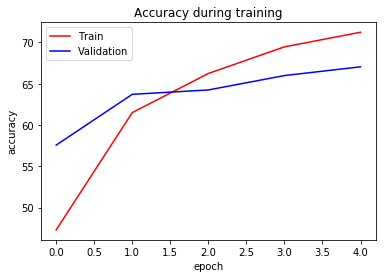

In [17]:
# Plot training and validation accuracy
plt.plot(train_acc_stat, color='red', label='Train')
plt.plot(valid_acc_stat, color='blue', label='Validation')
plt.title('Accuracy during training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

We can notice that though the training accuracy keeps increasing, validation accuracy not. This is because this simple network has overfitted.

Though the validation accuracy says that our model can predict 66% of the validation data correctly, but I believe you are still suspecting if that is true. Now let's ask the model to predict some data from the test set. 

At first, let's show the image we want to test. Remember that we did some normalization on our training set, so we need to unnormalize it. 

In [18]:
def cifar_show(img):
    img = img / 2 + 0.5   #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# 10 categories of CIFAR-10
cifar_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# get some random test images
dataiter = iter(testloader)

Everything is done, let's test our simple model! You can run the following cell multiple times to test different input images.

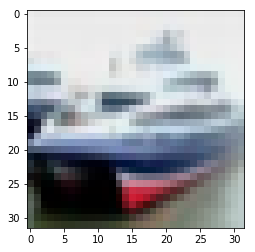

The label of your input image is ship


In [22]:
images = dataiter.next()

# show images
cifar_show(images[0][0])

X = to_variable(images[0])
out = model(X)
pred = out.data.max(1, keepdim=True)[1] # pick the most probable label as our prediction
print("The label of your input image is {0}".format(cifar_classes[int(pred)]))

## Summary and references

This tutorial just go through image classification roughly. If you want to learn more about things we cover in this tutorial, whatever packages, datasets or concepts, you can read the following references.

1. Pytorch: http://pytorch.org/
2. Pillow: https://pillow.readthedocs.io/en/latest/
3. Matplotlib: https://matplotlib.org/
4. ImageNet: http://image-net.org/
5. CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html
6. Convolutional Neural Network: http://cs231n.github.io/convolutional-networks/
7. Alexnet: https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
8. Pytorch Dataset and Dataloader: http://pytorch.org/tutorials/beginner/data_loading_tutorial.html